# Advanced tutorial for query to reference mapping using expiMap with de novo learned gene programs

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import pandas as pd
import numpy as np
import gdown

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [3]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import os
from scarches.plotting.terms_scores import plot_abs_bfs_key

In [4]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(5, 5))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)
plt.rcParams["axes.grid"] = False
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)

In [5]:
sc.settings.verbosity = 3

## Data info and model dir

In [6]:
adata_train = 'train_gmt.h5ad'
adata_train_umap = 'train_gmt_umap.h5ad'
adata_train_umap_metadata = 'train_gmt_umap_metadata.csv'

adata_query = 'query.h5ad'
adata_query_output = 'query_gmt.h5ad'
adata_query_metadata = 'query_gmt_umap_metadata.csv'

adata_train_query = 'train_query_gmt.h5ad'
adata_train_query_metadata = 'train_query_gmt_umap_metadata.csv'

latents_sub_adata_dir = 'latents_sub.h5ad'

In [7]:
model_train_dir = 'train_normal'
model_query_dir = 'query_normal'

In [8]:
output_dir = 'output/'
output_gene_dir = 'output/term_gene/'

if (os.path.exists(output_dir) != True):
    os.mkdir(output_dir)
if (os.path.exists(output_gene_dir) != True):
    os.mkdir(output_gene_dir)

In [9]:
MEAN=False

## RELOAD

In [10]:
query = sc.read(adata_query_output)
adata = sc.read_h5ad(adata_train)
query_pbmc = sc.AnnData.concatenate(adata, query, batch_key='batch_join', uns_merge='same')
select_terms = pd.read_csv((output_dir + 'train_query_top_term.csv'), index_col = 0)

In [11]:
latents_sub_adata = sc.read(latents_sub_adata_dir)
latents_sub_adata

AnnData object with n_obs × n_vars = 388646 × 369

In [12]:
latents_sub = pd.DataFrame(latents_sub_adata.X, columns = select_terms, index = latents_sub_adata.obs_names)
latents_sub

CPD001_PC3_24H:BRD-K76634210-001-08-9:10_UP  CPC006_HT29_6H:D19_UP  \
0                                         -0.105459               2.795866   
1                                         -4.689280              -1.858072   
2                                         13.605512              11.331152   
3                                          0.679153               2.267080   
4                                         -4.059682              -2.061713   
...                                             ...                    ...   
388641                                    -1.168099              -9.232951   
388642                                     1.473851              -3.286985   
388643                                    -3.245663             -10.268082   
388644                                    -4.384467              -1.822709   
388645                                    -3.717102               0.824274   

        CPC007_A375_24H:BRD-K29767311-001-04-2:10_DOWN  \
0                                            -3.672479   
1                                            -1.164966   
2                                            -2.431937   
3                                            -3.605609   
4                                            -4.840141   
...                                                ...   
388641                                        0.759502   
388642                                       -8.216646   
388643                                        0.101796   
388644                                       -7.572762   
388645                                       -3.946107   

        LJP008_SKL_24H:G19_DOWN  \
0                      5.366816   
1                     -5.790070   
2                     14.254625   
3                      3.064181   
4                     -3.415484   
...                         ...   
388641                -4.058743   
388642                -1.152748   
388643                -3.385308   
388644                -6.065278   
388645                 1.529977   

        CPC006_HT29_24H:BRD-K86574132-001-04-9:48_DOWN  \
0                                            -8.852678   
1                                             1.166786   
2                                            -2.229481   
3                                           -13.179527   
4                                            -1.049466   
...                                                ...   
388641                                       13.327890   
388642                                       14.170004   
388643                                       15.334271   
388644                                       15.299419   
388645                                       -2.583686   

        CPC006_PC3_24H:J14_DOWN  LJP005_SKBR3_24H:F19_DOWN  \
0                     -3.858171                  -6.193043   
1                     -5.101815                  -5.970469   
2                      6.018690                   4.911286   
3                     -1.422498                  -5.935510   
4                     -2.750540                  -2.797737   
...                         ...                        ...   
388641                -4.659647                  -5.669953   
388642                -3.073505                  -3.293490   
388643                -1.856234                  -6.494433   
388644                -8.148926                  -5.488447   
388645                -3.654519                  -4.410435   

        MOAR004_A375_24H:O05_DOWN  MUC.CP008_P1A82_24H:O19_UP  \
0                       -9.404079                   -1.416648   
1                        2.877859                    1.793851   
2                        1.356279                    0.982212   
3                       -9.462224                    1.499882   
4                       -4.306069                   -1.579314   
...                           ...                         ...   
388641                  14.656141                   -5.1

In [13]:
for terms in range(len(select_terms)): 
        query_pbmc.obs[select_terms[terms]] = latents_sub[[select_terms[terms]]].values

In [15]:
query_pbmc_bfscores_all = pd.read_csv(output_dir + 'train_query_bfscores_recluster_new.csv', index_col=0) 
query_pbmc_bfscores_all

Lymphoid.C6_Plasma cell_MT high  \
REP.A012_HEK293_24H:B07_UP                                        -0.001675   
REP.A012_HEK293_24H:B07_DOWN                                      -0.011875   
REP.A012_MCF7_24H:B07_UP                                          -0.030662   
REP.A012_MCF7_24H:B07_DOWN                                         0.007924   
REP.A012_MCF7_24H:B13_UP                                           0.028358   
...                                                                     ...   
CPC006_MCF7_24H:I11_DOWN                                          -0.017848   
CPC006_PC3_24H:I11_UP                                             -0.005289   
CPC006_PC3_24H:I11_DOWN                                           -0.041231   
HDAC002_MCF7_24H:BRD2492_+_BRD3308:10_UP                          -0.184116   
HDAC002_MCF7_24H:BRD2492_+_BRD3308:10_DOWN                        -0.002425   

                                            Other.C12_Other  \
REP.A012_HEK293_24H:B07_UP                         0.001728   
REP.A012_HEK293_24H:B07_DOWN                      -0.024860   
REP.A012_MCF7_24H:B07_UP                          -0.008957   
REP.A012_MCF7_24H:B07_DOWN                         0.040707   
REP.A012_MCF7_24H:B13_UP                           0.025041   
...                                                     ...   
CPC006_MCF7_24H:I11_DOWN                           0.014104   
CPC006_PC3_24H:I11_UP                              0.016294   
CPC006_PC3_24H:I11_DOWN                           -0.042651   
HDAC002_MCF7_24H:BRD2492_+_BRD3308:10_UP          -0.122250   
HDAC002_MCF7_24H:BRD2492_+_BRD3308:10_DOWN        -0.007544   

                                            Stromal.C6_Smooth muscle cell  \
REP.A012_HEK293_24H:B07_UP                                      -0.034759   
REP.A012_HEK293_24H:B07_DOWN                                    -0.027645   
REP.A012_MCF7_24H:B07_UP                                         0.056297   
REP.A012_MCF7_24H:B07_DOWN                                       0.041164   
REP.A012_MCF7_24H:B13_UP                                         0.071125   
...                                                                   ...   
CPC006_MCF7_24H:I11_DOWN                                        -0.011116   
CPC006_PC3_24H:I11_UP                                            0.007781   
CPC006_PC3_24H:I11_DOWN                                         -0.114011   
HDAC002_MCF7_24H:BRD2492_+_BRD3308:10_UP                        -0.148892   
HDAC002_MCF7_24H:BRD2492_+_BRD3308:10_DOWN                      -0.019487   

                                            Lymphoid.C10_Plasma cell_IGLC high  \
REP.A012_HEK293_24H:B07_UP                                            0.004030   
REP.A012_HEK293_24H:B07_DOWN                                         -0.021238   
REP.A012_MCF7_24H:B07_UP                                             -0.054123   
REP.A012_MCF7_24H:B07_DOWN                                            0.041901   
REP.A012_MCF7_24H:B13_UP                                              0.046504   
...                                                                        ...   
CPC006_MCF7_24H:I11_DOWN                                             -0.029679   
CPC006_PC3_24H:I11_UP                                                 0.038040   
CPC006_PC3_24H:I11_DOWN                                              -0.056917   
HDAC002_MCF7_24H:BRD2492_+_BRD3308:10_UP                             -0.386023   
HDAC002_MCF7_24H:BRD2492_+_BRD3308:10_DOWN                            0.006989   

                                            Lymphoid.C8_Proliferating T cell  \
REP.A012_HEK293_24H:B07_UP                                         -0.044060   
REP.A012_HEK293_24H:B07_DOWN                                        0.024328   
REP.A012_MCF7_24H:B07_UP                                            0.036963   
REP.A012_MCF7_24H:B07_DOWN                                         -0.011565   
REP.A012_MCF7_24H:B13_UP    

In [21]:
query_pbmc_raw = sc.read(adata_train_query)
query_pbmc_raw

AnnData object with n_obs × n_vars = 388646 × 8500
    obs: 'Cell', 'nCount_RNA', 'nFeature_RNA', 'reads', 'depth', 'percent.mt', 'Sample_Name', 'Patient', 'Cancer_Type', 'Tissue_Source', 'Cluster', 'Celltype', 'Celllineage', 'Annotation', 'sample_cluster', 'sample_celltype', 'sample_lineage', 'Tissue', 're_clusters', 're_annotation', 're_cluster_annotation', 're_clusters_raw', 'Malignangt', 're_cluster_merge', 're_cluster_merge2', 'batch', 'batch_join', 're_annotation_use', 'selection', 'query_group'
    var: 'n_cells-0', 'highly_variable-0', 'highly_variable_rank-0', 'means-0', 'variances-0', 'variances_norm-0'
    uns: 'Malignangt_colors', 'Tissue_Source_colors', 'Tissue_colors', 'active_terms', 'bf_scores', 'directions', 'neighbors', 're_annotation_use_colors', 're_cluster_annotation_colors', 're_cluster_merge2_colors', 're_cluster_merge_colors', 'sample_lineage_colors', 'selection_colors', 'terms', 'umap'
    obsm: 'X_cvae_direction', 'X_umap'
    layers: 'counts'

In [83]:
for terms in range(len(select_terms)): 
        query_pbmc_raw.obs[select_terms[terms]] = latents_sub[[select_terms[terms]]].values

## Step0 preprocess

In [128]:
sc.settings.figdir = "Stromal_top_term/"

In [129]:
query_terms = ['CPD001_PC3_24H:BRD-K76634210-001-08-9:10_UP', 
'LJP005_SKBR3_24H:F19_DOWN', 
'LJP008_SKL_24H:G19_DOWN', 
'DOSVAL003_HA1E_24H:BRD-A53134341:5_DOWN', 
'MOA001_U2OS_24H:P04_DOWN', 
'CPC006_HT29_6H:D19_UP', 
'CPC006_PC3_24H:J14_DOWN', 
'CPC016_ASC_24H:BRD-A17065207-001-06-9:10_DOWN', 
'LJP005_MCF7_24H:O22_DOWN', 
'ASG003_MCF7_48H:E07_UP',
               
'CPC007_A375_24H:BRD-K29767311-001-04-2:10_DOWN',
'MUC.CP008_P1A82_24H:O19_UP',
'DOSVAL003_HCC515_24H:BRD-K61734568:10_UP',
'CPC002_VCAP_24H:BRD-A44780397-001-01-1:10_UP',
'CPC006_HT29_6H:D19_UP',
'CPC018_HEPG2_6H:BRD-K65503129-001-04-8:10_DOWN',
'CPC006_HA1E_6H:BRD-K67844266-001-01-3:11.1_UP',
'CPC006_PC3_24H:J14_DOWN',
'CPC008_HEPG2_6H:BRD-K62466453-001-04-7:10_DOWN',
'CPC016_ASC_24H:BRD-A17065207-001-06-9:10_DOWN'
              ]

In [130]:
query_pbmc_bfscores_query_terms = query_pbmc_bfscores_all.loc[query_terms]
query_pbmc_bfscores_query_terms

Lymphoid.C6_Plasma cell_MT high  \
CPD001_PC3_24H:BRD-K76634210-001-08-9:10_UP                            0.301742   
LJP005_SKBR3_24H:F19_DOWN                                              0.125792   
LJP008_SKL_24H:G19_DOWN                                                0.366432   
DOSVAL003_HA1E_24H:BRD-A53134341:5_DOWN                                0.274385   
MOA001_U2OS_24H:P04_DOWN                                              -0.130701   
CPC006_HT29_6H:D19_UP                                                  0.232408   
CPC006_PC3_24H:J14_DOWN                                               -0.091823   
CPC016_ASC_24H:BRD-A17065207-001-06-9:10_DOWN                          0.006448   
LJP005_MCF7_24H:O22_DOWN                                               0.231954   
ASG003_MCF7_48H:E07_UP                                                 0.039351   
CPC007_A375_24H:BRD-K29767311-001-04-2:10_DOWN                        -0.196556   
MUC.CP008_P1A82_24H:O19_UP                                            -0.443399   
DOSVAL003_HCC515_24H:BRD-K61734568:10_UP                              -0.386522   
CPC002_VCAP_24H:BRD-A44780397-001-01-1:10_UP                           0.285448   
CPC006_HT29_6H:D19_UP                                                  0.232408   
CPC018_HEPG2_6H:BRD-K65503129-001-04-8:10_DOWN                         0.309501   
CPC006_HA1E_6H:BRD-K67844266-001-01-3:11.1_UP                          0.122292   
CPC006_PC3_24H:J14_DOWN                                               -0.091823   
CPC008_HEPG2_6H:BRD-K62466453-001-04-7:10_DOWN                         0.290752   
CPC016_ASC_24H:BRD-A17065207-001-06-9:10_DOWN                          0.006448   

                                                Other.C12_Other  \
CPD001_PC3_24H:BRD-K76634210-001-08-9:10_UP            0.201328   
LJP005_SKBR3_24H:F19_DOWN                             -0.170040   
LJP008_SKL_24H:G19_DOWN                               -0.163565   
DOSVAL003_HA1E_24H:BRD-A53134341:5_DOWN                0.030244   
MOA001_U2OS_24H:P04_DOWN                              -0.291558   
CPC006_HT29_6H:D19_UP                                 -0.223324   
CPC006_PC3_24H:J14_DOWN                               -0.303947   
CPC016_ASC_24H:BRD-A17065207-001-06-9:10_DOWN         -0.553981   
LJP005_MCF7_24H:O22_DOWN                              -0.304534   
ASG003_MCF7_48H:E07_UP                                -0.239966   
CPC007_A375_24H:BRD-K29767311-001-04-2:10_DOWN        -0.344898   
MUC.CP008_P1A82_24H:O19_UP                             0.194032   
DOSVAL003_HCC515_24H:BRD-K61734568:10_UP              -0.209420   
CPC002_VCAP_24H:BRD-A44780397-001-01-1:10_UP          -0.149235   
CPC006_HT29_6H:D19_UP                                 -0.223324   
CPC018_HEPG2_6H:BRD-K65503129-001-04-8:10_DOWN        -0.016624   
CPC006_HA1E_6H:BRD-K67844266-001-01-3:11.1_UP          0.532757   
CPC006_PC3_24H:J14_DOWN                               -0.303947   
CPC008_HEPG2_6H:BRD-K62466453-001-04-7:10_DOWN         0.298962   
CPC016_ASC_24H:BRD-A17065207-001-06-9:10_DOWN         -0.553981   

                                                Stromal.C6_Smooth muscle cell  \
CPD001_PC3_24H:BRD-K76634210-001-08-9:10_UP                          2.221541   
LJP005_SKBR3_24H:F19_DOWN                                            1.943687   
LJP008_SKL_24H:G19_DOWN                                              1.855532   
DOSVAL003_HA1E_24H:BRD-A53134341:5_DOWN                              1.430090   
MOA001_U2OS_24H:P04_DOWN                                             1.721403   
CPC006_HT29_6H:D19_UP                                                2.245001   
CPC006_PC3_24H:J14_DOWN                                              1.880408   
CPC016_ASC_24H:BRD-A17065207-001-06-9:10_DOWN                        1.088064   
LJP005_MCF7_24H:O22_DOWN                                             1.816619   
ASG003_MCF7_48H:E07_UP                                               0.958808   
CPC00

In [ ]:
query_pbmc_subset2 = query_pbmc[query_pbmc.obs['sample_lineage'].isin(['Stromal', 'Endothelial'])]

## Step1 All top terms_Violin

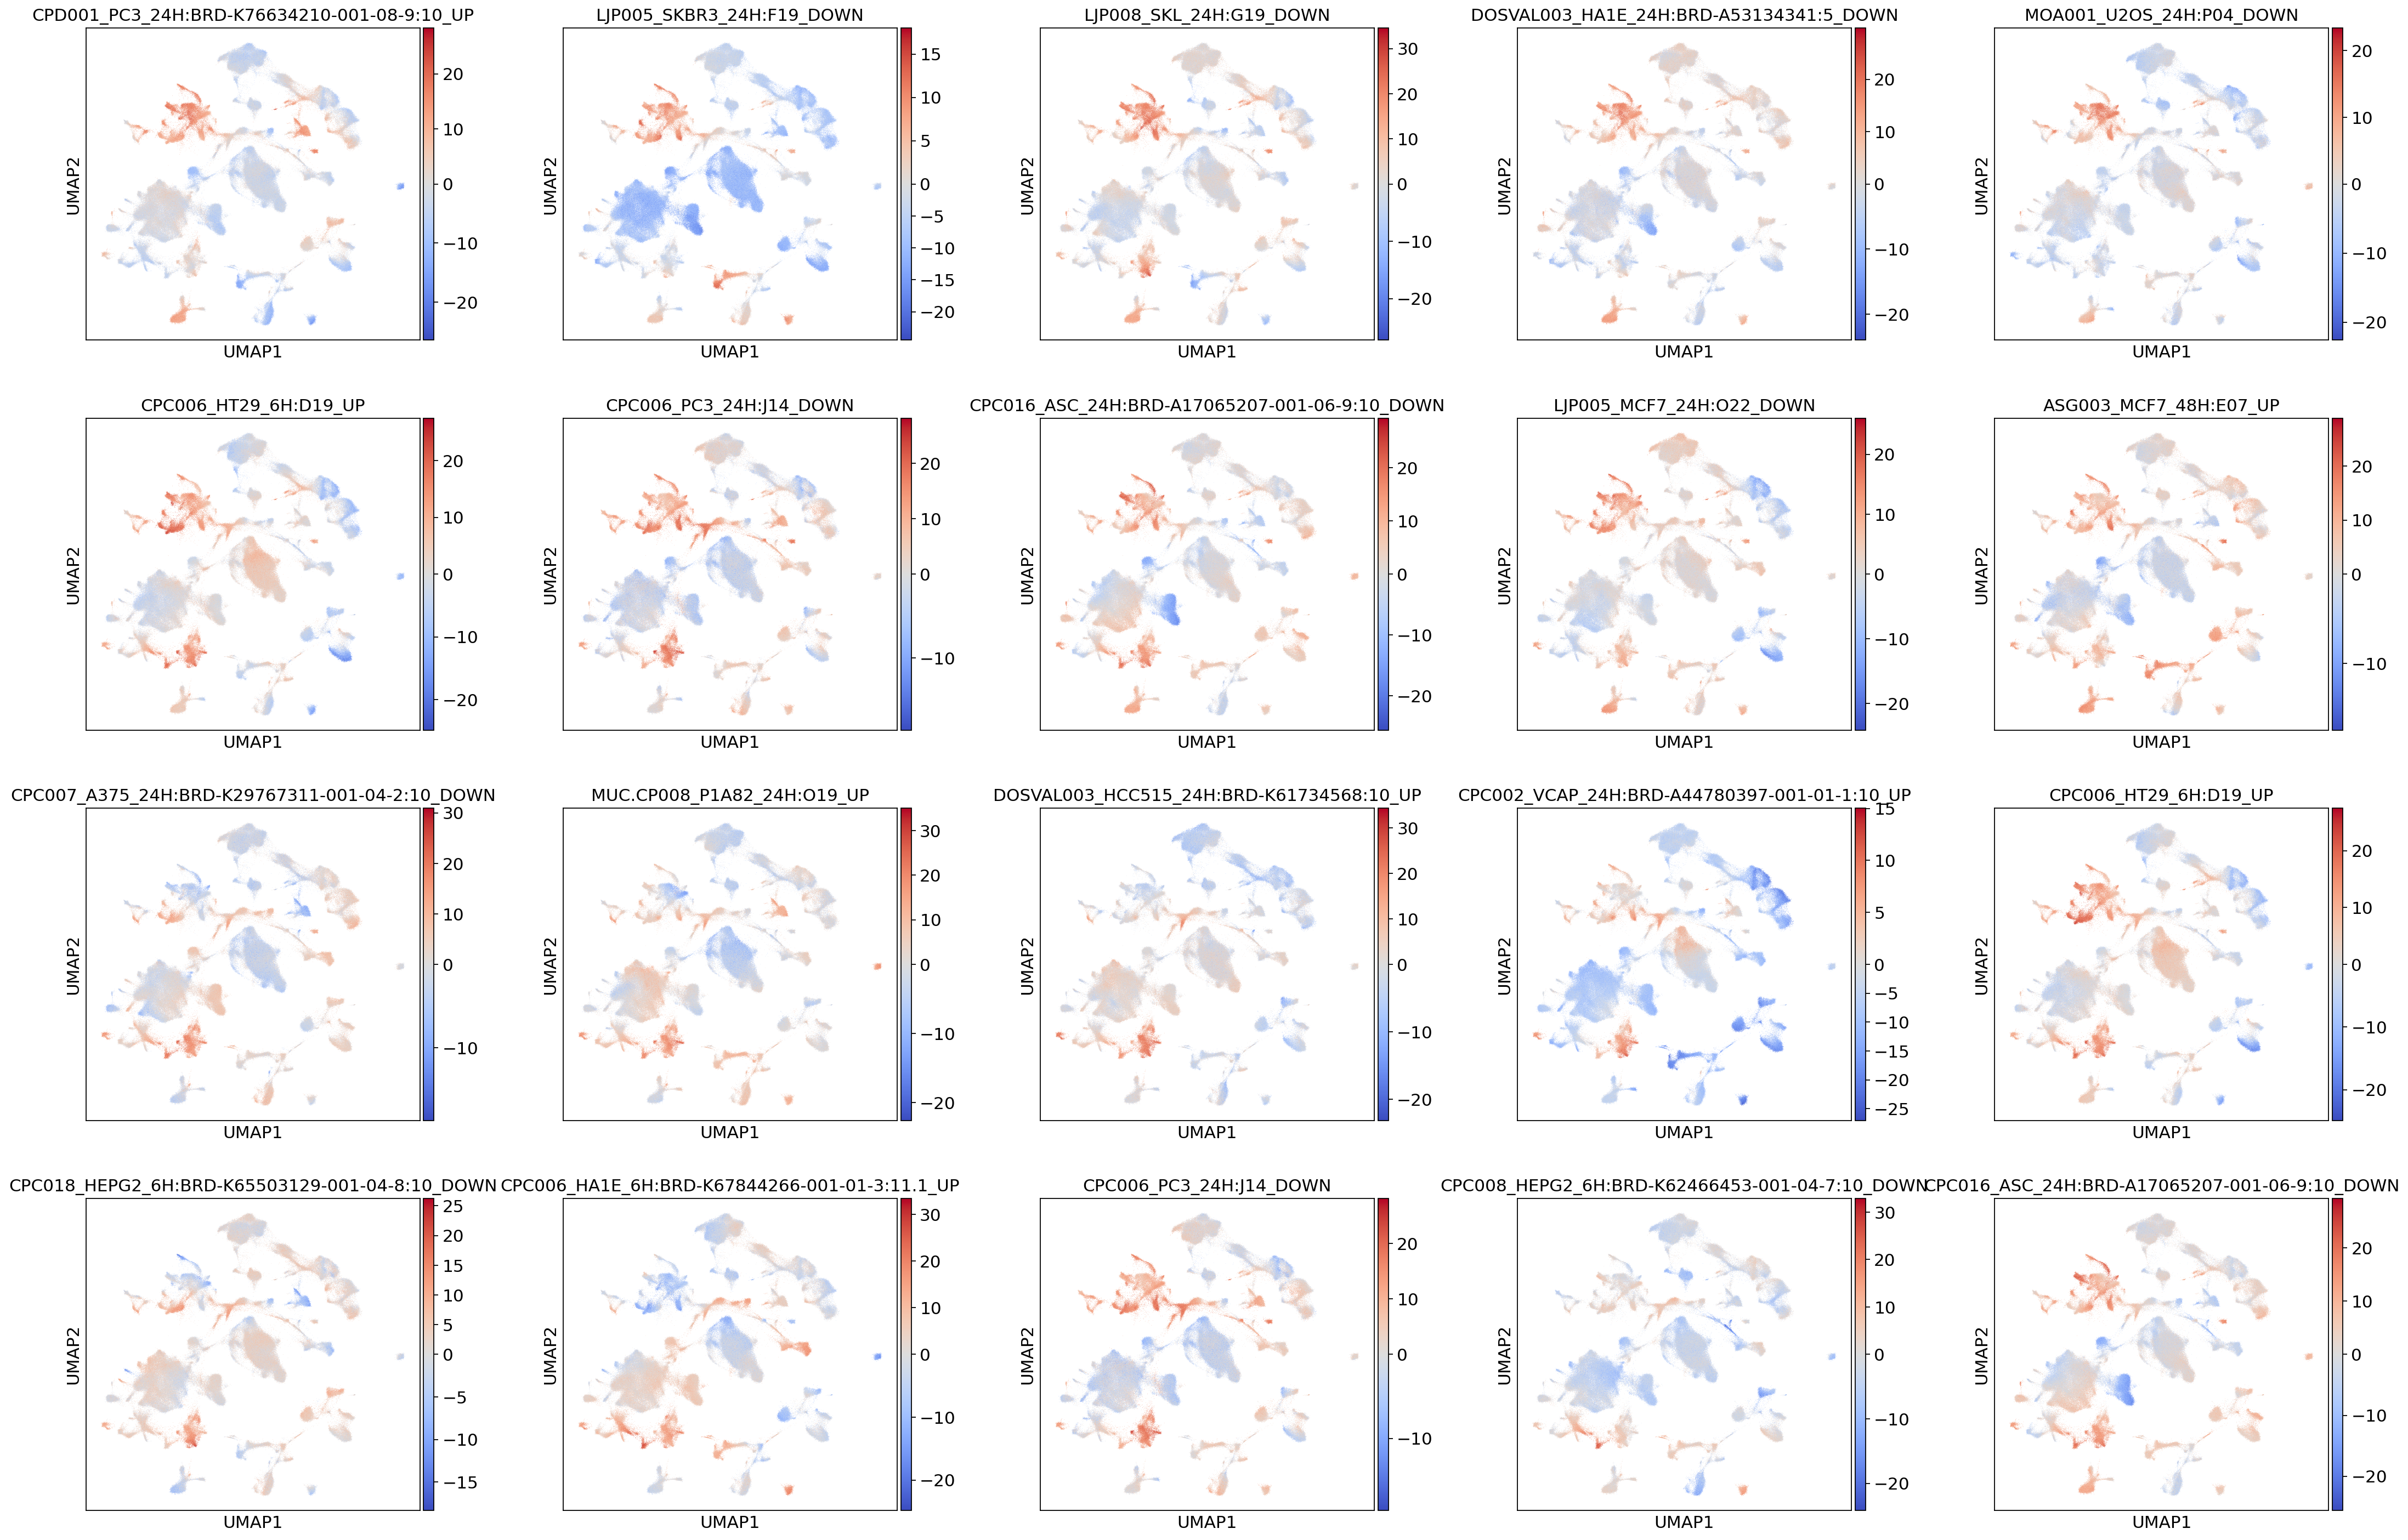

In [140]:
sc.pl.umap(query_pbmc_raw,color=list(query_terms),
           cmap='coolwarm',
           vcenter=0,wspace=0.3,
           sort_order=False,
           ncols=5
          )

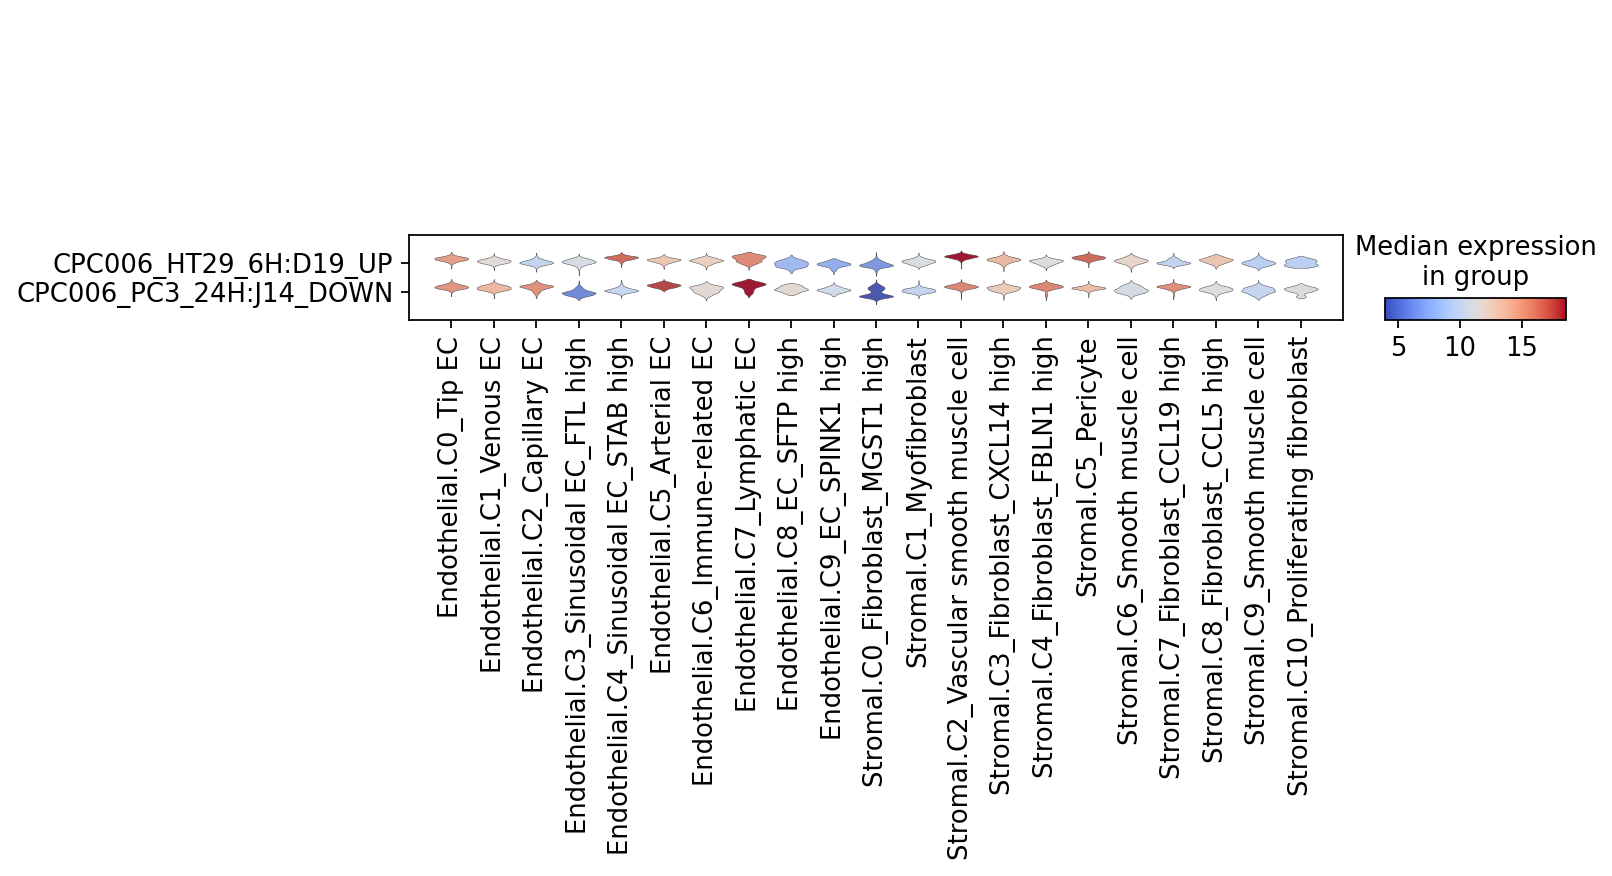

In [138]:
query_pbmc_raw_subset2 = query_pbmc_raw[query_pbmc_raw.obs['sample_lineage'].isin(['Stromal', 'Endothelial'])]
sc.pl.stacked_violin(query_pbmc_subset2, var_names=[query_terms[5], query_terms[6]], 
                     groupby='re_cluster_merge2', cmap='coolwarm', swap_axes=True,
                    )

## Step2 Top terms_Scatter

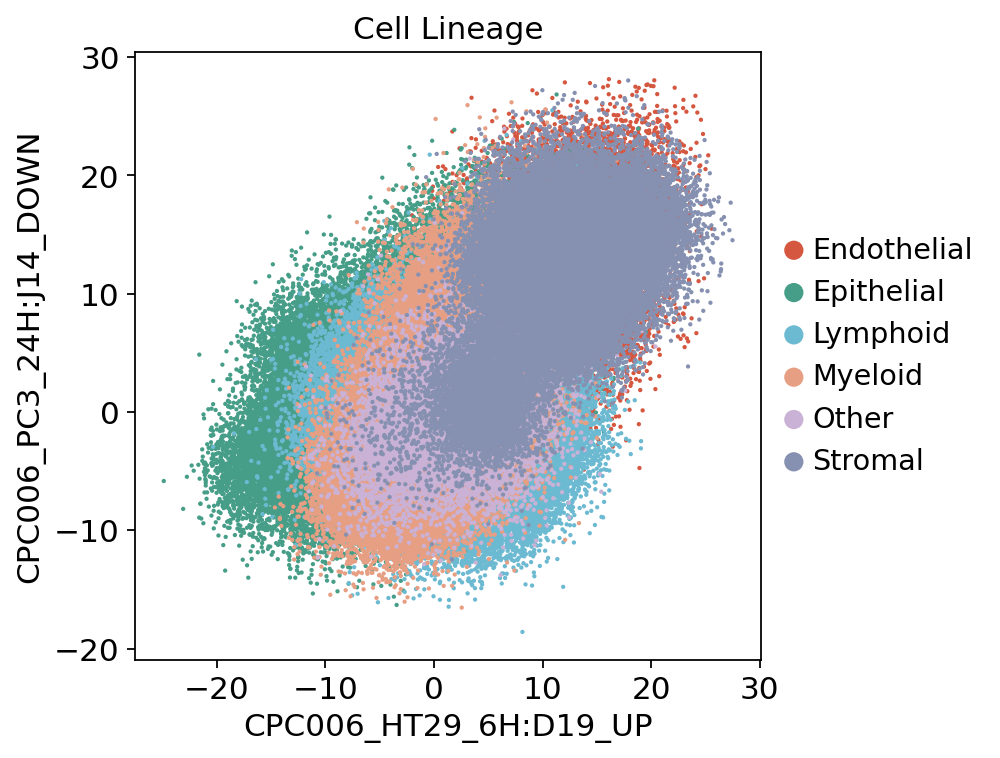

In [192]:
sc.pl.scatter(query_pbmc, x=query_terms[5], y=query_terms[6], color='sample_lineage', size=15, 
              palette =  ["#d55740", "#479e88", "#6cb9d2", "#e79f84", "#CAB2D6", "#8691b1"], 
              title = 'Cell Lineage')

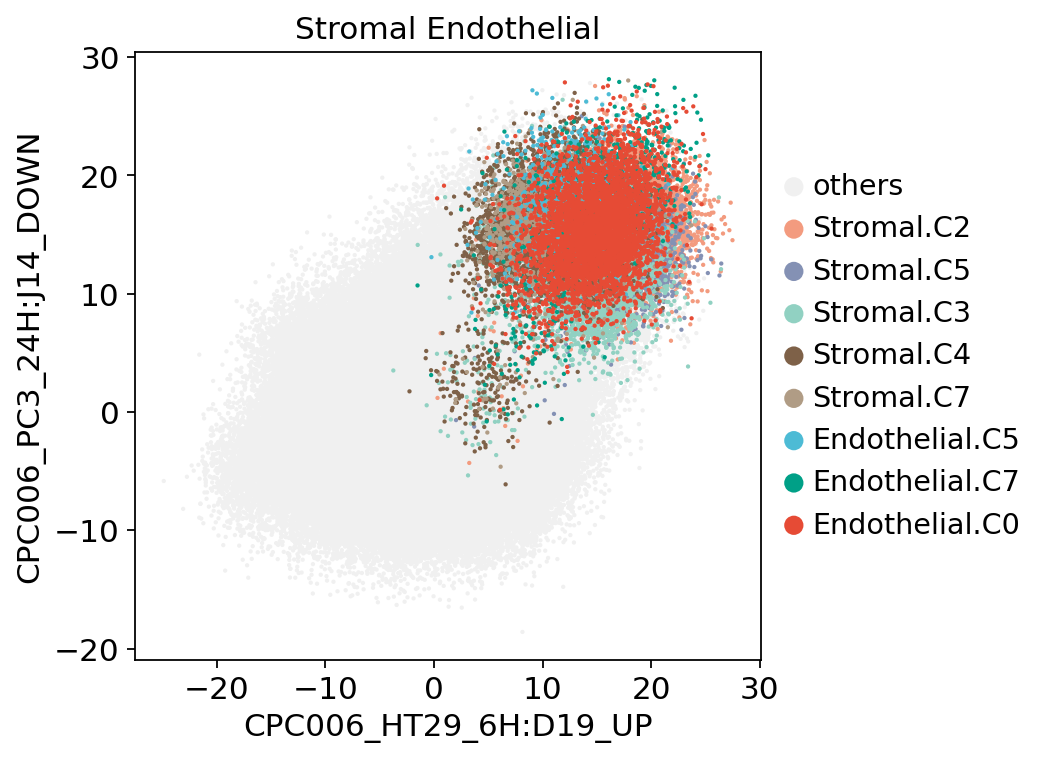

In [203]:
query_pbmc.uns['cells_use_colors'] = ['#f0f0f0', 
                                      "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#7E6148FF",
                                      "#B09C85FF", 
                                      "#4DBBD5FF", "#00A087FF", "#E64B35FF"]
query_pbmc.obs["cells_use"] = "others"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Endothelial.C0"] = "Endothelial.C0"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Endothelial.C5"] = "Endothelial.C5"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Endothelial.C7"] = "Endothelial.C7"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Stromal.C2"] = "Stromal.C2"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Stromal.C5"] = "Stromal.C5"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Stromal.C3"] = "Stromal.C3"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Stromal.C4"] = "Stromal.C4"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Stromal.C7"] = "Stromal.C7"
query_pbmc.strings_to_categoricals()
query_pbmc.obs['cells_use'].cat.reorder_categories(['others','Stromal.C2','Stromal.C5',
                                                    'Stromal.C3', 'Stromal.C4', 'Stromal.C7', 'Endothelial.C5',
                                                    'Endothelial.C7', 'Endothelial.C0'], inplace=True)
sc.pl.scatter(query_pbmc, x=query_terms[5], y=query_terms[6], color='cells_use', size=15,
              title = 'Stromal Endothelial')

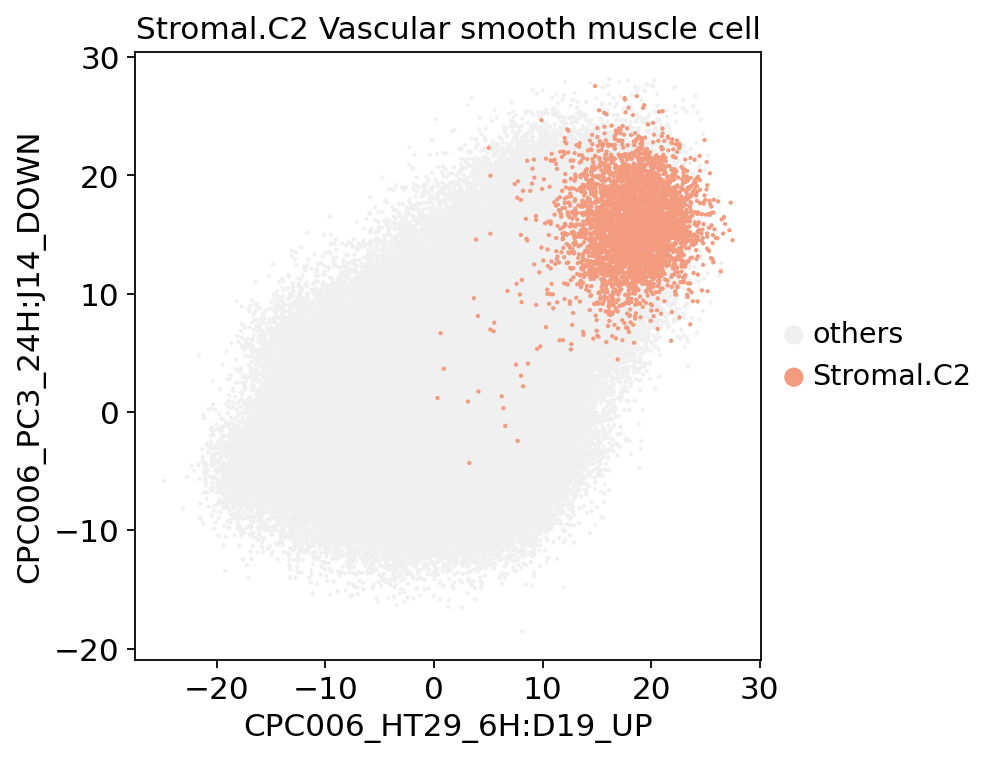

In [198]:
query_pbmc.uns['cells_use_colors'] = ['#f0f0f0', "#F39B7FFF"]

query_pbmc.obs["cells_use"] = "others"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Stromal.C2"] = "Stromal.C2"
query_pbmc.strings_to_categoricals()
query_pbmc.obs['cells_use'].cat.reorder_categories(['others','Stromal.C2'], inplace=True)
sc.pl.scatter(query_pbmc, x=query_terms[5], y=query_terms[6], color='cells_use', size=15,
              title = 'Stromal.C2 Vascular smooth muscle cell')

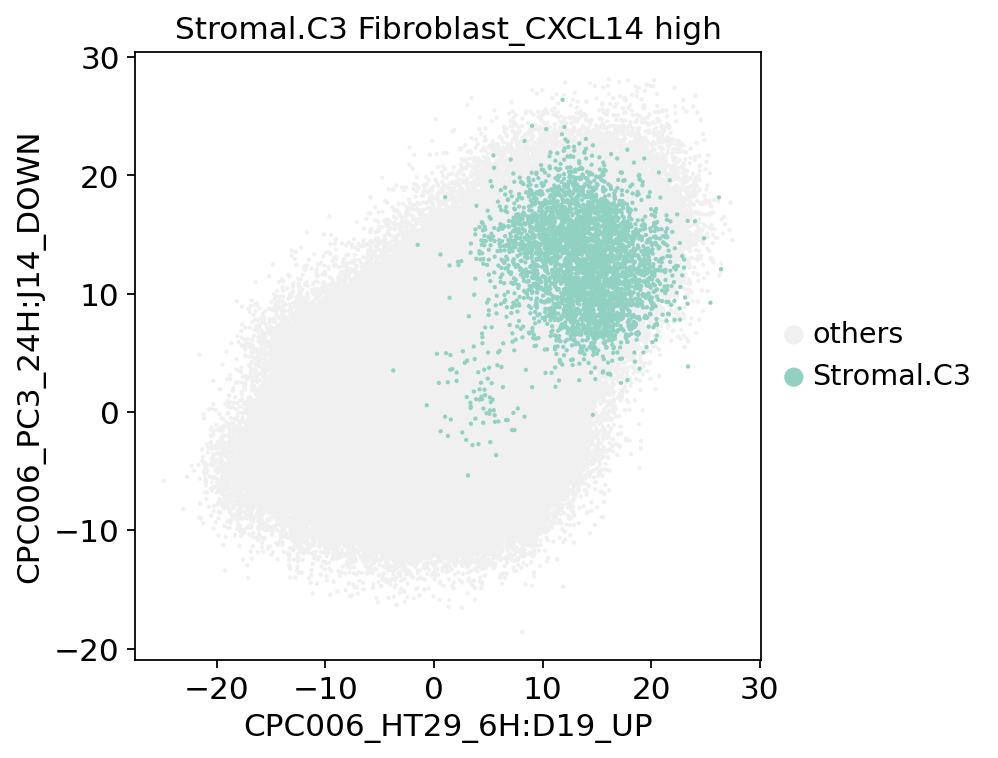

In [199]:
query_pbmc.uns['cells_use_colors'] = ['#f0f0f0', "#91D1C2FF"]

query_pbmc.obs["cells_use"] = "others"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Stromal.C3"] = "Stromal.C3"
query_pbmc.strings_to_categoricals()
query_pbmc.obs['cells_use'].cat.reorder_categories(['others','Stromal.C3'], inplace=True)
sc.pl.scatter(query_pbmc, x=query_terms[5], y=query_terms[6], color='cells_use', size=15,
              title = 'Stromal.C3 Fibroblast_CXCL14 high')

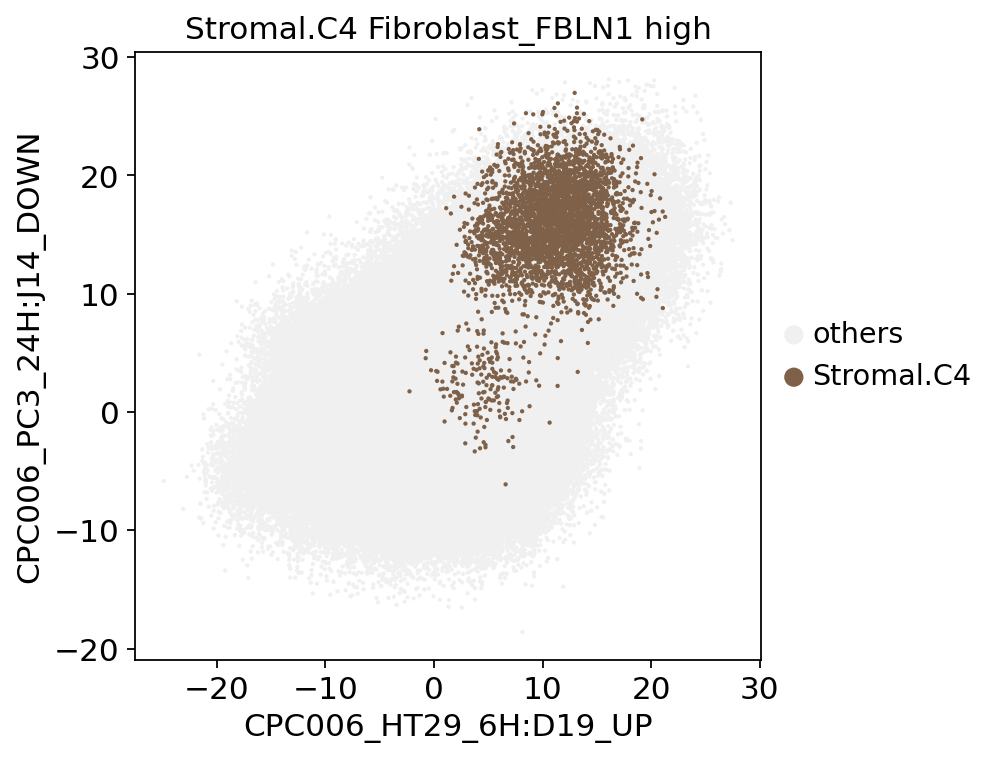

In [200]:
query_pbmc.uns['cells_use_colors'] = ['#f0f0f0', "#7E6148FF"]

query_pbmc.obs["cells_use"] = "others"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Stromal.C4"] = "Stromal.C4"
query_pbmc.strings_to_categoricals()
query_pbmc.obs['cells_use'].cat.reorder_categories(['others','Stromal.C4'], inplace=True)
sc.pl.scatter(query_pbmc, x=query_terms[5], y=query_terms[6], color='cells_use', size=15,
              title = 'Stromal.C4 Fibroblast_FBLN1 high')

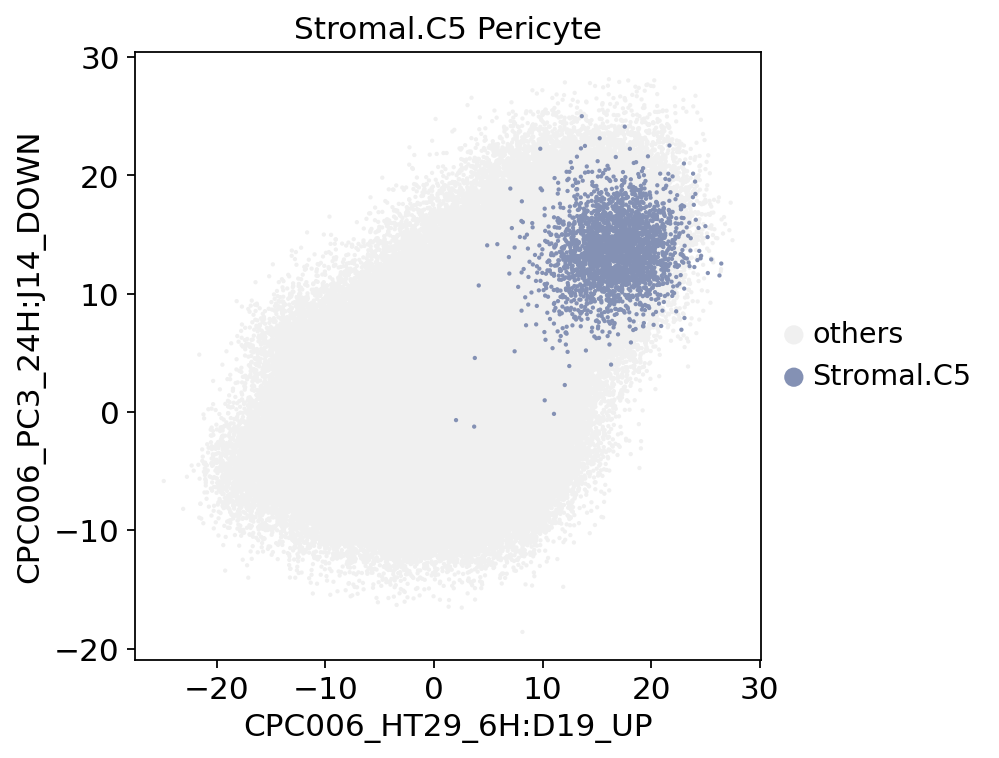

In [201]:
query_pbmc.uns['cells_use_colors'] = ['#f0f0f0', "#8491B4FF"]

query_pbmc.obs["cells_use"] = "others"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Stromal.C5"] = "Stromal.C5"
query_pbmc.strings_to_categoricals()
query_pbmc.obs['cells_use'].cat.reorder_categories(['others','Stromal.C5'], inplace=True)
sc.pl.scatter(query_pbmc, x=query_terms[5], y=query_terms[6], color='cells_use', size=15,
              title = 'Stromal.C5 Pericyte')

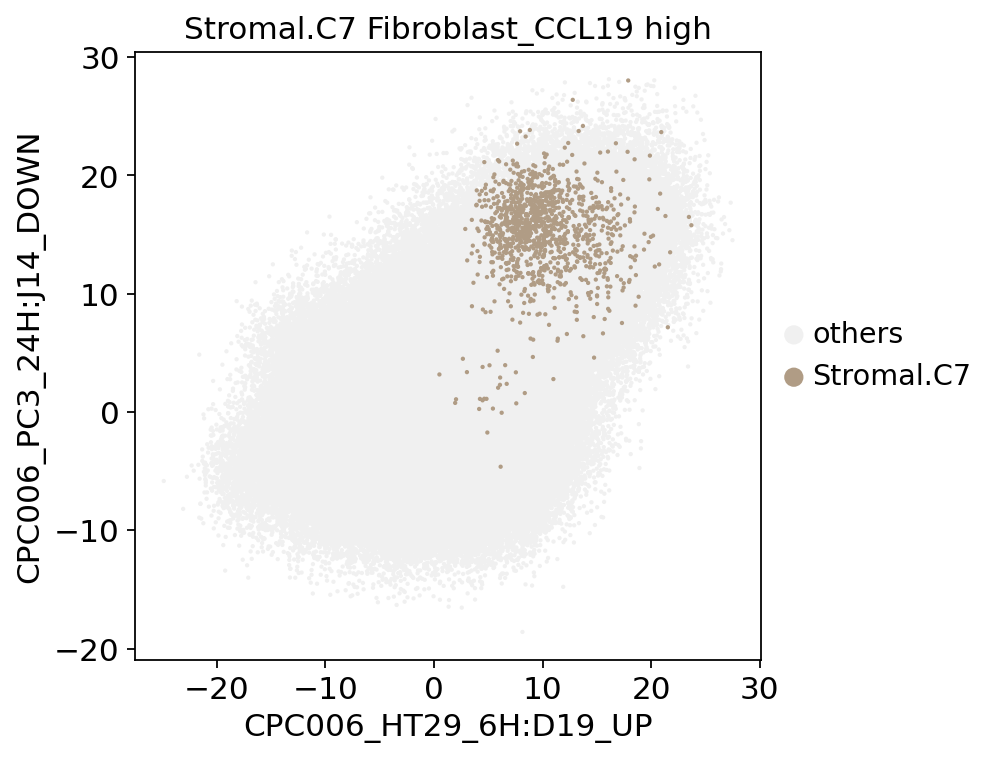

In [202]:
query_pbmc.uns['cells_use_colors'] = ['#f0f0f0', "#B09C85FF"]

query_pbmc.obs["cells_use"] = "others"
query_pbmc.obs["cells_use"][query_pbmc.obs.re_cluster_merge == "Stromal.C7"] = "Stromal.C7"
query_pbmc.strings_to_categoricals()
query_pbmc.obs['cells_use'].cat.reorder_categories(['others','Stromal.C7'], inplace=True)
sc.pl.scatter(query_pbmc, x=query_terms[5], y=query_terms[6], color='cells_use', size=15,
              title = 'Stromal.C7 Fibroblast_CCL19 high')